<a name="top"></a>
<div style="width:1000 px">

<div style="float:right; width:98 px; height:98px;">
<img src="https://cdn.miami.edu/_assets-common/images/system/um-logo-gray-bg.png" alt="Miami Logo" style="height: 98px;">
</div>

<h1>MPO 624: Calibrating the F test for spectral peaks</h1>
<h2>Does power have one or two DOF's per frequency?</h2>

<div style="clear:both"></div>
</div>

<hr style="height:2px;">

### Methods of time series analysis
1. <a href="#spectrum">Specify spectrum, make long series</a>
1. <a href="#chopchop">Chop segments and compute their pow(freqs) spectra</a>
1. <a href="#peak5">Find the 5th highest peak</a>
1. <a href="#results">RESULTS: 2 DOFs</a>

--------

# The question

#### If the power spectrum is only half the information content of the input data, does it really count as 2 pieces of information (squared amplitude of sine component plus squared amplitude of cosine component)? Or is it just 1 DOF? 

# The Plan
### 1. make long realization of white time series (amplitude 1 for clarity) 
### 2. fft segments of that realization to make power spectrum P(f)
### 3. For each realization, find the argument and value of the 5th percentile peak
### 4. Compare those values (ratio over 1) to F(1,inf) and F(2,inf)

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
plt.xkcd() # whiteboard style, informal looking

----------------
<a name="spectrum"></a>
### White spectrum exactly, make a long long realization

In [3]:
NT = 10000
AMP = 1. 
ampli = AMP + zeros(NT)
ampli[0] = 0 # make the series have zero time-mean
power = ampli**2 

## Synthesize data w/ known P(f), random phase. 
#### Notice that 1j is *i* in Python 

In [4]:
# Phase = rand() makes synthetic data w/ uniform distribution
phase = 2*pi*rand( len(ampli) )

In [5]:
# Build the synthetic spectrum from real and imaginary parts
spec =  (    ampli*cos(phase)   #real part
       + 1j* ampli*sin(phase) ) #imag part

# Synthesize back into physical space (time domain) with ifft: 
# First, we have to rescale by N = len(y). 
# there's a very-near-zero imaginary part; strip it off with real()
data = real( ifft(spec)* sqrt(NT) ) 

Text(0.5,1,'variance 0.9977307094868142')

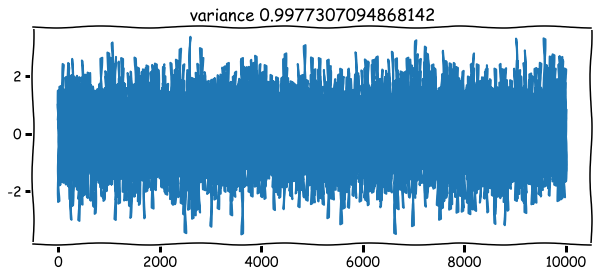

In [6]:
figsize(10,4)
data = data*sqrt(2) # to make variance unity, fft's quirks
plot(data); title('variance '+str(var(data)))

------------
<a name='chopchop'></a>
# Chop segments and make their P(f) 
### segpow will be power for the positive-f half of the symm spectrum

In [7]:
NTseg = 200 # length of segment

# Define positive half of the frequencies "freqs" 
freqs = np.array(range(NTseg//2))  

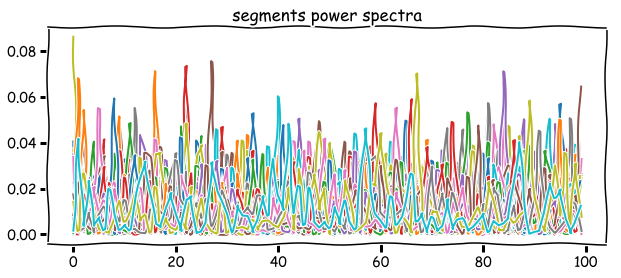

In [22]:
for iseg in range(NT//NTseg): 
    seg = data[ NTseg*iseg : NTseg*(iseg+1) ]
#    plot(seg)
    segspec = fft.fft(seg) /NTseg
    segpow2  = real(segspec.conjugate()*segspec)
    segpow = segpow2[0:NTseg//2]*2 # double P for f>0 half
    plot(freqs[0:NTseg//2],segpow[0:NTseg//2]); title('segments power spectra')
    xlabel(freqs)
# Check Parseval's theorem on total variance
#    print(sum(segpow[0:NTseg//2]))

------------

<a name='peak5'></a>
# For each segment
## find ratio of top 5 %ile segment power above analytic value
### To compare to the F test 

In [9]:
# Analytic power spectrum is total variance over NTseg/2 bins
analyticpow = AMP**2 / (NTseg/2)
analyticpow

0.01

Text(0.5,0,'frequency')

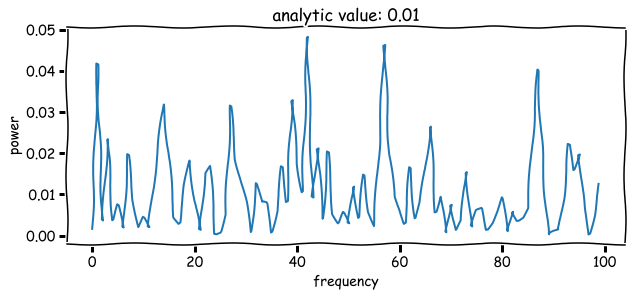

In [20]:
# example, last segment from previous loop 
plot(freqs[0:NTseg//2],segpow[0:NTseg//2] )
title('analytic value: '+str(analyticpow))
ylabel('power'); xlabel('frequency')

In [11]:
# Dividing by 20 gets you the 5th percentile 
NTseg//2//20 

5

------------

<a name='results'></a>
# Which is closer? 
#### F(2,inf) for p=0.05 is 3.07, vs. 3.92 for F(1,inf)
#### F(inf,2) for p=0.05 is 19.49, vs. 254.3 for F(inf,1)
from [here](http://www.socr.ucla.edu/Applets.dir/F_Table.html#FTable0.05) for example
# Answer: clearly, 2 DOFs

In [12]:
# one random sample, from the end of above loop
ratio = segpow[0:NTseg//2] / analyticpow
argsorted = argsort(ratio)
valsorted = sort(ratio)
print('95th %ile peak ratio to analytic: 3.1 or 3.9? ')
print(valsorted[-NTseg//2//20])

95th %ile peak ratio to analytic: 3.1 or 3.9? 
3.2906791574789125


In [13]:
# Loop over segments and get the mean result 
res95 = [3.1]
print('95th %ile peak ratio to analytic: 3.1 or 3.9? ')
for iseg in range(NT//NTseg): 
    seg = data[ NTseg*iseg : NTseg*(iseg+1) ]
#    plot(seg)
    segspec = fft.fft(seg) /NTseg
    segpow2  = real(segspec.conjugate()*segspec)
    segpow = segpow2[0:NTseg//2]*2 # double P for f>0 half
# Check Parseval's theorem on total variance
#    print(sum(segpow[0:NTseg//2]))
    ratio = segpow[0:NTseg//2] / analyticpow
    argsorted = argsort(ratio)
    valsorted = sort(ratio)
    print(      valsorted[-NTseg//2//20])
    res95.append(valsorted[-NTseg//2//20])
    
print('mean result '+str(mean(res95[1:])))

95th %ile peak ratio to analytic: 3.1 or 3.9? 
2.1900678015830657
2.5806684418619668
3.3082746756254915
2.747964108866194
3.245753047089919
3.2273979064124694
2.818198300513777
3.271071264091335
3.7062952239857587
2.857281783320169
3.0729220351901847
3.3985662206070666
3.3261154789564316
3.750948279540112
2.8428728456342602
4.041963768550875
2.5922537159464794
2.8247350701668523
3.296392015865056
2.9548664054312286
2.690258978103572
2.7251683641325246
2.9906773221920213
3.0750779246852837
2.829406707017235
3.564349242967973
3.3235494495981857
2.7555866872103656
2.4675636829062846
2.696926696204615
3.3368777297977603
4.09325909956108
3.1563209962313152
3.3965437941526786
2.881490552450607
3.4942752919106743
2.905583850394862
2.783266686002312
3.752086293926317
2.9075826157950417
3.4592524598489516
3.124181126272891
2.982086400518871
3.166660743923606
2.517985907209188
3.014744420840686
2.6245254681184695
3.240992056655444
3.1036427584596806
3.2906791574789125
mean result 3.0881042170761

In [19]:
print('5th %ile peak ratio to analytic (inverse): 19.5 or 254? ')
res5 = [19.]
for iseg in range(NT//NTseg): 
    seg = data[ NTseg*iseg : NTseg*(iseg+1) ]
#    plot(seg)
    segspec = fft.fft(seg) /NTseg
    segpow2  = real(segspec.conjugate()*segspec)
    segpow = segpow2[0:NTseg//2]*2 # double P for f>0 half
# Check Parseval's theorem on total variance
#    print(sum(segpow[0:NTseg//2]))
    ratio = segpow[0:NTseg//2] / analyticpow
    argsorted = argsort(ratio)
    valsorted = sort(ratio)
    print(  str(1.0/valsorted[NTseg//2//20])+' at freq '+str(argsorted[NTseg//2//20]))
    res5.append(1.0/valsorted[NTseg//2//20])
    
print('mean result '+str(mean(res5[1:])))

5th %ile peak ratio to analytic (inverse): 19.5 or 254? 
22.896714423711423 at freq 10
9.079043861018876 at freq 72
16.078609798817105 at freq 98
23.655717111718474 at freq 28
19.68053224946876 at freq 34
42.82409952692302 at freq 10
17.84903447383632 at freq 85
19.3837416497064 at freq 94
27.50509792488864 at freq 25
13.694006239712492 at freq 30
12.887981218822858 at freq 29
24.093996481450084 at freq 68
15.398614141051139 at freq 23
14.782531423956863 at freq 87
46.90274098097331 at freq 44
16.464032682377834 at freq 78
25.582359862266536 at freq 55
14.810471919219928 at freq 33
48.281618096174505 at freq 75
15.309730518998146 at freq 50
16.39604417738222 at freq 20
18.125148333606862 at freq 79
18.579554339763526 at freq 68
9.734018615566193 at freq 98
7.865371667916174 at freq 20
17.33390129234071 at freq 39
22.073267086107197 at freq 35
43.48558285861812 at freq 67
8.334257788070376 at freq 14
15.428097828721587 at freq 0
21.69955085410495 at freq 60
18.716114256094187 at freq 11

In [16]:
argsorted[5]

31